# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torchvision.models import resnet18, ResNet18_Weights, inception_v3, Inception_V3_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchinfo import summary
from collections import defaultdict

### Dataset acquisition

Create a compose transformation to resize, and convert each image to pytorch tensor and normalization according to ImageNet images mean and std.

In [2]:
transform_imagenet = Compose([
                Resize(size=(299,299)),
                ToTensor(),
                Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = Compose([
                ToTensor(),
                Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

In [3]:
DATA_PATH = './cifar10'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
dataset_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Detect the device used for training (mps, cpu or cuda)

In [4]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if device.type == 'cuda':
        # Allow TensorFloat32 on matmul and convolutions
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        torch.set_float32_matmul_precision("medium")

print(f"Available device: {device.type}")

Available device: cuda


Show a random image from the test dataset

La imagen muestreada representa un: bird


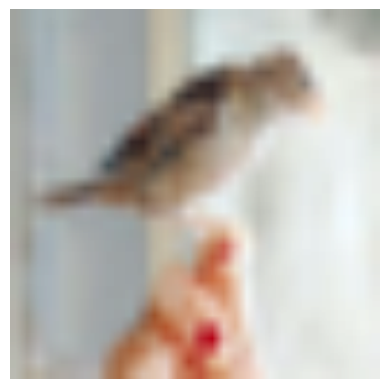

In [5]:
classes = test_loader.dataset.classes
num_classes = len(test_loader.dataset.classes)

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

Definition of accuracy function

In [6]:
class Accuracy(nn.Module):
    
    def __init__(self):
        super(Accuracy, self).__init__()
        self.size = 0
        self.num_correct = 0
    
    @torch.no_grad()
    def forward(self, scores: torch.Tensor, target: torch.Tensor):
        _, y_hat = scores.max(dim=1)
        correct = (y_hat == target).sum()
        self.num_correct += correct
        self.size += target.size(0)
        
        return (correct / target.size(0)).cpu().item() # mini-batch accuracy
    
    @torch.no_grad()
    def accuracy(self):
        result = self.num_correct / self.size  # epoch accuracy
        self.num_correct = 0
        self.size = 0
        return result.cpu().item()

Definition of train batch function

In [7]:
def train_batch(model: nn.Module, dataset_loader, accuracy: Accuracy, optimizer):
    model.train()
    losses = []
    for i, (xi, yi) in enumerate(dataset_loader):
        xi = xi.to(device=device, dtype=torch.float32)
        yi = yi.to(device=device, dtype=torch.long)
        
        scores = model(xi)
        loss = F.cross_entropy(input=scores, target=yi)
        
        accuracy(scores, yi)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.reshape(1))
    
    return torch.mean(torch.cat(losses)).cpu().item()
        

def test_batch(model: nn.Module, dataset_loader, accuracy: Accuracy):
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (xi, yi) in enumerate(dataset_loader):
            xi, yi = xi.to(device), yi.to(device)
            
            scores = model(xi)
            loss = F.cross_entropy(input= scores, target=yi)
            accuracy(scores, yi)
            losses.append(loss.reshape(1))
    
    return torch.mean(torch.cat(losses)).cpu().item()

Training Loop

In [8]:
def train(model, optimizer, train_loader, test_loader, epochs=100):
    model = model.to(device=device)
    train_accuracy = Accuracy()
    test_accuracy = Accuracy()
    
    results = defaultdict(list)
    
    for epoch in range(epochs):
        train_loss = train_batch(model, train_loader, train_accuracy, optimizer)
        test_loss = test_batch(model, test_loader, test_accuracy)
        train_acc, test_acc = train_accuracy.accuracy(), test_accuracy.accuracy()
        
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)
        results['train_acc'].append(train_acc)
        results['test_acc'].append(test_acc)
        
        print(f"epoch={epoch} train loss={train_loss:>7f} train accuracy={100 * train_acc:>0.1f}%  test loss={test_loss:>7f} test accuracy={100 * test_acc:>0.1f}%")
        
    return results

In [9]:
class Cifar10TLModel(nn.Module):
    
    def __init__(self, model, linear_input, num_classes, remove):
        super(Cifar10TLModel, self).__init__()
        
        for param in model.parameters():
            param.requires_grad = False
        
        self.sequential = nn.Sequential(
            nn.Sequential(*list(model.children())[:-remove]),
            nn.Flatten(),
            nn.Linear(linear_input, num_classes)
        )
        
    def forward(self, image):
        out = self.sequential(image)
        return out

### ResNet18

In [10]:
model_resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

In [11]:
summary(model_resnet18, input_data=torch.ones(1,3,299,299), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [1, 3, 299, 299]          [1, 1000]                 --
├─Conv2d: 1-1                            [1, 3, 299, 299]          [1, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 150, 150]         [1, 64, 150, 150]         128
├─ReLU: 1-3                              [1, 64, 150, 150]         [1, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [1, 64, 150, 150]         [1, 64, 75, 75]           --
├─Sequential: 1-5                        [1, 64, 75, 75]           [1, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [1, 64, 75, 75]           [1, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [1, 64, 75, 75]           [1, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 75, 75]           [1, 64, 75, 75]           128
│    │    └─ReLU: 3-3     

In [12]:
model1 = Cifar10TLModel(model_resnet18, 512, num_classes, remove=1)
optimizer = torch.optim.Adam(model1.parameters())

In [13]:
resnet_results = train(model1, optimizer, dataset_loader, val_loader, epochs=5)

epoch=0 train loss=1.086404 train accuracy=64.9%  test loss=0.817489 test accuracy=71.7%
epoch=1 train loss=0.793878 train accuracy=73.1%  test loss=0.714168 test accuracy=75.7%
epoch=2 train loss=0.744655 train accuracy=74.5%  test loss=0.696051 test accuracy=76.0%
epoch=3 train loss=0.716338 train accuracy=75.3%  test loss=0.690159 test accuracy=75.9%
epoch=4 train loss=0.703657 train accuracy=75.7%  test loss=0.692924 test accuracy=75.9%


### InceptionV3

In [14]:
model_inceptionV3 = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
model_inceptionV3.aux_logits = False
model_inceptionV3.AuxLogits = None

In [15]:
summary(model_inceptionV3, input_data=torch.ones(1,3,299,299), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Inception3                               [1, 3, 299, 299]          [1, 1000]                 --
├─BasicConv2d: 1-1                       [1, 3, 299, 299]          [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 3, 299, 299]          [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 149, 149]         [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 149, 149]         [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 32, 147, 147]         [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 32, 147, 147]         [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6    

In [16]:
model2 = Cifar10TLModel(model_inceptionV3, 2048, num_classes, remove=2)
optimizer = torch.optim.Adam(model2.parameters())

In [17]:
inception_results = train(model2, optimizer, dataset_loader, val_loader, epochs=5)

epoch=0 train loss=0.937218 train accuracy=70.0%  test loss=0.726740 test accuracy=75.3%
epoch=1 train loss=0.713584 train accuracy=75.7%  test loss=0.676530 test accuracy=76.6%
epoch=2 train loss=0.669878 train accuracy=77.2%  test loss=0.679340 test accuracy=77.0%
epoch=3 train loss=0.644912 train accuracy=77.8%  test loss=0.677897 test accuracy=76.3%
epoch=4 train loss=0.628936 train accuracy=78.4%  test loss=0.631759 test accuracy=77.6%


### MobileNet

In [18]:
model_mobileNet = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

In [19]:
summary(model_mobileNet, input_data=torch.ones(1,3,299,299), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
MobileNetV3                                        [1, 3, 299, 299]          [1, 1000]                 --
├─Sequential: 1-1                                  [1, 3, 299, 299]          [1, 576, 10, 10]          --
│    └─Conv2dNormActivation: 2-1                   [1, 3, 299, 299]          [1, 16, 150, 150]         --
│    │    └─Conv2d: 3-1                            [1, 3, 299, 299]          [1, 16, 150, 150]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 150, 150]         [1, 16, 150, 150]         32
│    │    └─Hardswish: 3-3                         [1, 16, 150, 150]         [1, 16, 150, 150]         --
│    └─InvertedResidual: 2-2                       [1, 16, 150, 150]         [1, 16, 75, 75]           --
│    │    └─Sequential: 3-4                        [1, 16, 150, 150]         [1, 16, 75, 75]           744
│    └─InvertedResidual: 2-3           

In [20]:
model3 = Cifar10TLModel(model_mobileNet, 576, num_classes, remove=1)
optimizer = torch.optim.Adam(model3.parameters())

In [21]:
mobilenet_results = train(model3, optimizer, dataset_loader, val_loader, epochs=5)

epoch=0 train loss=1.057793 train accuracy=68.9%  test loss=0.789585 test accuracy=74.3%
epoch=1 train loss=0.709709 train accuracy=77.1%  test loss=0.667768 test accuracy=77.1%
epoch=2 train loss=0.635936 train accuracy=79.2%  test loss=0.601810 test accuracy=79.3%
epoch=3 train loss=0.598504 train accuracy=79.9%  test loss=0.577521 test accuracy=80.1%
epoch=4 train loss=0.573024 train accuracy=80.9%  test loss=0.563764 test accuracy=79.7%


### Training Results

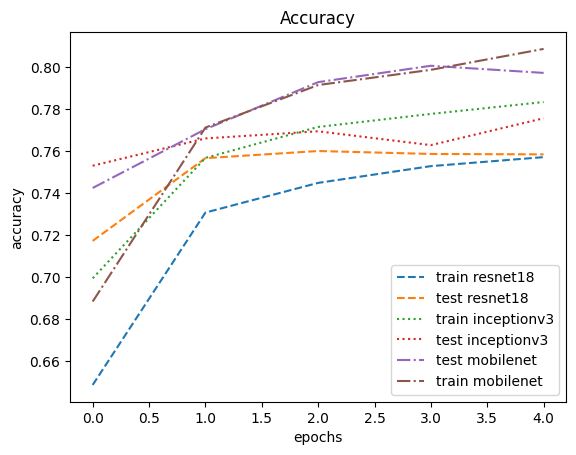

In [22]:
x = range(5)

plt.plot(x, resnet_results["train_acc"], label="train resnet18", linestyle = 'dashed')
plt.plot(x, resnet_results["test_acc"], label="test resnet18", linestyle = 'dashed')

plt.plot(x, inception_results['train_acc'], label="train inceptionv3", linestyle = 'dotted')
plt.plot(x, inception_results['test_acc'], label="test inceptionv3", linestyle = 'dotted')

plt.plot(x, mobilenet_results['test_acc'], label="test mobilenet", linestyle = 'dashdot')
plt.plot(x, mobilenet_results['train_acc'], label="train mobilenet", linestyle = 'dashdot')

plt.legend()
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

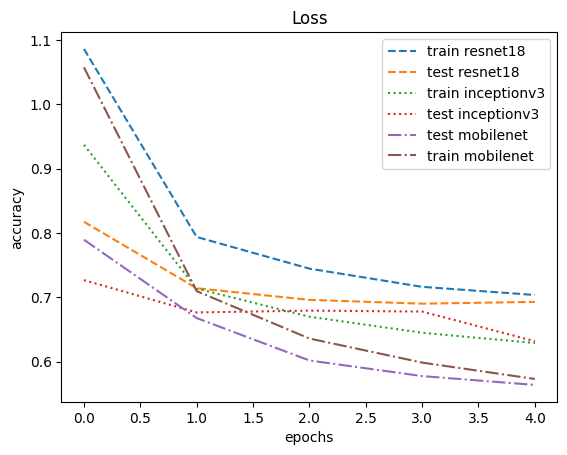

In [23]:
x = range(5)

plt.plot(x, resnet_results["train_loss"], label="train resnet18", linestyle = 'dashed')
plt.plot(x, resnet_results["test_loss"], label="test resnet18", linestyle = 'dashed')

plt.plot(x, inception_results['train_loss'], label="train inceptionv3", linestyle = 'dotted')
plt.plot(x, inception_results['test_loss'], label="test inceptionv3", linestyle = 'dotted')

plt.plot(x, mobilenet_results['test_loss'], label="test mobilenet", linestyle = 'dashdot')
plt.plot(x, mobilenet_results['train_loss'], label="train mobilenet", linestyle = 'dashdot')

plt.legend()
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()